#**Машинное обучение ИБ-2024**

#**Домашнее задание 1.**
#Регрессия, KNN, LinearRegression.

В данной домашней работе мы будем строить модели для предсказания цены квартиры в России. Ниже приведено описание некоторых колонок набора данных.

date - дата публикации объявления

price - цена в рублях

level- этаж, на котором находится квартира

levels - количество этажей в квартире

rooms - количество комнат в квартире. Если значение -1, то квартира считается апартаментами.

area - площадь квартиры.

kitchen_area - площадь кухни.

geo_lat - Latitude

geo_lon - Longitude

building_type - материал застройки. 0 - Don't know. 1 - Other. 2 - Panel. 3 - Monolithic. 4 - Brick. 5 - Blocky. 6 - Wooden

#Часть 0. Начало работы

Для начала работы с данными импортируем библиотеки, которые понадобятся в данном задании.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib as plt
import sklearn
import seaborn as sns

Загрузим библиотеку folium для отображения данных на карте по координатам.

In [2]:
!pip install folium

Распакуем наши данные из архива.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/DataDZ1.zip

Archive:  /content/drive/MyDrive/DataDZ1.zip
  inflating: input_data.csv          


Загрузим данные из csv файла в датафрейм.

In [5]:
df = pd.read_csv('/content/input_data.csv', delimiter=';')
df.sample(5)

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
8324750,2021-09-27,660000,6,9,1,20.1,5.0,58.097226,38.733231,0,0,152914.0,153161.0,76,2251718.0
8335910,2021-09-27,5500000,8,12,3,80.0,15.0,56.502730,85.076110,0,0,634031.0,NaN,70,NaN
9334113,2021-10-27,2800000,10,16,1,36.7,9.6,56.104212,47.325528,0,0,428028.0,355769.0,21,1677978.0
4528730,2021-06-05,2670000,3,9,2,43.0,7.6,51.718700,39.267741,4,0,394010.0,512244.0,36,875308.0
5212836,2021-06-30,5701400,14,14,-1,29.0,7.4,55.701240,37.883905,2,2,140007.0,467353.0,50,2694227.0


Отобразим на карте координаты наших построек.

In [6]:
import folium
from IPython.display import display

map_df = df[:1000]

m = folium.Map(location=[55.751244, 37.618423], zoom_start=10)

# Список точек с широтой и долготой
lats = map_df['geo_lat'].loc[:1000]
longs = map_df['geo_lon'].loc[:1000]
# Добавляем точки на карту
for point in zip(lats, longs):
    folium.Marker(
        location=[point[0], point[1]]
    ).add_to(m)

display(m)

# Часть 1. Подготовим данные для обработки моделями машинного обучения.

**0.5 Балл**. География наших наблюдений в наборе данных крайне большая. Однако мы знаем, что стоимость квартир в Москве и Санкт-Петербурге намного выше, чем в среднем по России. Давайте сделаем признаки, который показывают, находится ли квартира в 20 килиметрах от центра Москвы или находится ли квартира в 20 килиметрах от центра Санкт-Петербурга.

Создайте два признака is_Moscow и is_Saint_Peterburg. Для нахождения расстояния по координатам используйте функцию haversine_distance.

In [7]:
from sklearn.metrics.pairwise import haversine_distances as distance
from math import radians

Moscow = [radians(_) for _ in [55.755811, 37.617617]]
Piter = [radians(_) for _ in [59.938670, 30.314350]]

df['geo_lat_rad'] = df['geo_lat'].apply(radians)
df['geo_lon_rad'] = df['geo_lon'].apply(radians)
df[['is_Moscow', 'is_Saint_Peterburg']]= distance(df[['geo_lat_rad', 'geo_lon_rad']], [Moscow, Piter]) * 6371 <= 20

**0.5 Балла**. В нашем наборе данных есть признаки, которые мы теоретически можем использовать, например postal_code, но мы это будем делать в рамках домашней работы очень-очень долго. Поэтому предлагается удалить ненужные признаки из датафрейма.

Удалим geo_lat,	geo_lon,	object_type,	postal_code,	street_id,	id_region,	house_id.

In [8]:
dont_need = ['geo_lat',
             'geo_lon',
             'object_type',
             'postal_code',
             'street_id',
             'id_region',
             'house_id',
             'geo_lat_rad',
             'geo_lon_rad']
need = [col for col in df.columns if col not in dont_need]

df_small = df[need]

**0.5 Балл**. Для начала Вам предлагается проанализировать Ваши оставшиеся признаки (колонки) в наборе данных. Какие колонки категориальные? Какие числовые?

Категориальные: date, building_type,	is_Moscow,	is_Saint_Peterburg

Числовые: price,	level,	levels,	rooms,	area,	kitchen_area

Дата может быть как числовым так и категориальным признаком в зависимости от формата представления.

Давайте закодируем категориальные признаки с помощью OneHot-Encoding. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

**0.5 Балл**. Поработаем с числовыми признаками:


1.   Добавьте в ваш датасет два признака: количество дней со дня первого наблюдения (разница между датами объявлений). Возможно, для предсказания цены не так важен этаж, как важно отношение этажа квартиры на количество этажей в доме, добавьте этот признак. После добавления нового признака колонку date можно удалить.
2.   Числовые признаки могут иметь разные порядки. Давайте отнормируем числовые признаки с помощью StandartScaller https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html.



Сделаем обе задачи вместе

In [9]:
catigorials = [
     'building_type',
     'is_Moscow',
     'is_Saint_Peterburg'
]
numberic = [
    'level',
    'levels',
    'rooms',
    'area',
    'kitchen_area',
    'days',
    'level_part'
]
target = 'price'

features = catigorials+numberic

Добавим колонку отношения этажа к их общему количеству в доме

In [19]:
df_small['level_part'] = df_small['level']/df_small['levels']
df_small.replace([np.inf, -np.inf], np.nan, inplace=True)
df_small.dropna(subset = 'level_part', how="all", inplace=True)

<ipython-input-19-fdd64c115e34>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['level_part'] = df_small['level']/df_small['levels']
<ipython-input-19-fdd64c115e34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-19-fdd64c115e34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.dropna(sub

Добавим колонку количества дней

In [21]:
date_start = df_small['date'].min()
df_small['days'] = (pd.to_datetime(df_small['date']) - pd.to_datetime(date_start)).dt.days

<ipython-input-21-05ac7cd24c98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['days'] = (pd.to_datetime(df_small['date']) - pd.to_datetime(date_start)).dt.days


In [22]:
del df_small['date']
del df
df_small.sample(5)

,price,level,levels,rooms,area,kitchen_area,building_type,is_Moscow,is_Saint_Peterburg,level_part,days
2446022,1998000,7,9,2,47.00,8.0,4,False,False,0.777778,87
2201763,14094000,12,12,2,65.25,0.0,0,False,False,1.000000,80
10259438,5300000,10,10,3,67.00,9.3,0,False,False,1.000000,326
4350013,3600000,5,14,1,41.00,9.3,3,False,False,0.357143,149
842492,4100000,3,15,1,40.00,0.0,4,False,False,0.200000,39


Не очень честно учить препроцессор на val части, поэтому сразу разобьем выборку а затем научим его на train выборке.


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X = df_small[features]
y = df_small[target]

X_train, X_val , y_train, y_val = train_test_split(
    X, y, test_size = 0.2, random_state=42, shuffle = True
)

Соберем вместе обработчики катигориальных и численных фичей

Обучим их только на тренировочной выборке

In [24]:
preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), numberic),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", drop='if_binary', sparse_output=False),
            catigorials,
        ),
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

Давайте таргет тоже нормализуем

In [25]:
tar_scal = StandardScaler()
y_train = tar_scal.fit_transform(y_train.to_numpy().reshape(-1,1))
y_val = tar_scal.fit_transform(y_val.to_numpy().reshape(-1,1))



**2 Балла**. Реализуйте класс KNNRegressor, который должен делать регрессию методом k ближайших соседей.

In [26]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity
from sklearn.base import RegressorMixin
from tqdm.notebook import tqdm

In [27]:
class KNNRegressor(RegressorMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
      metrics = {
          'manhattan' : manhattan_distances,
          'cosine' : cosine_similarity,
          'euclidean' : euclidean_distances
      }
      self.n = n_neighbors
      self.metric = metrics[metric]

      self. X = []
      self.y = []
    def fit(self, X, y):
      self.X = X
      self.y = y.reshape(-1)

    def predict(self, X):
      rasstoyanie = self.metric(self.X, X) #считаем расстояние по метрике до точек входного массива
      # сложность памяти - n*m где n - изначальные обучающие точки, m - искомые.
      # Предсказания желательно делать по батчам, реализуем это при подсчете предсказаний модели
      min = np.zeros((self.n, X.shape[0]))

      for i in range(self.n): #Для каждого из n соседей
        args = np.argmin(rasstoyanie, axis=0) #находим минимальные расстояния для каждой точки
        coords = (args, np.arange(args.shape[0])) #находим и заменяем в массиве расстояний минимальные
        rasstoyanie[coords] = np.inf
        min[i] = np.array([self.y[arg] for arg in args]) #запоминаем значения 'y' для ближайшего сосда каждой точки

      return min.mean(axis=0)

**3 Балла**. Реализуйте класс LinearRegression, поддерживающий обучение градиентными спусками SGD, Momentum, AdaGrad. Используйте градиент для оптимизации функции потерь MSE.

Моментум

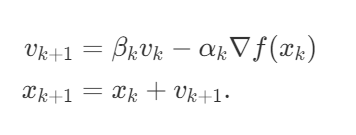

AdaGrad

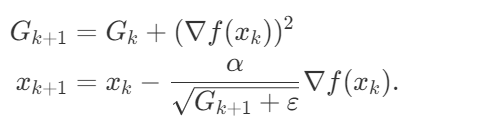

In [43]:
from sklearn.utils import shuffle

class LinearRegressor(RegressorMixin):
    def __init__(self, learning_rate=0.01, optimization='SGD', epsilon=1e-8, decay_rate=0.9, max_iter=10000,  batch_size=32, epoch = 3):
        self.learning_rate = learning_rate
        self.optimization = optimization
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None
        self.batch_size = batch_size
        self.epochs = epoch

    def fit(self, X, y):

        self.weights = np.random.normal(size = X.shape[1])
        self.bias = np.random.normal(size = 1)

        #введем переменные для моментум и адаград
        last_grad_w = 0
        last_grad_b = 0
        last_g_w = 0
        last_g_b = 0
        iter = 0
        for epoch in tqdm(range(self.epochs)):
          X,y = shuffle(X, y, random_state=42)
          for k in range(self.batch_size, X.shape[0], self.batch_size):
            if iter % 100000 == 0:
              self.learning_rate = self.learning_rate * 0.5

            X_batch = X[k - self.batch_size:k]
            y_batch = y[k - self.batch_size:k].reshape(-1)
            f = X_batch.dot(self.weights) + self.bias
            err = f - y_batch
            grad_w = 2*X_batch.T.dot(err)/self.batch_size
            grad_b = 2 * err.sum() / self.batch_size

            if self.optimization == 'Momentum': #делаем шаг с учетом импульса

              grad_w = grad_w * (1 - self.decay_rate) + last_grad_w * self.decay_rate
              grad_b = grad_b * (1 - self.decay_rate) + last_grad_b * self.decay_rate
              last_grad_w = grad_w
              last_grad_b = grad_b

              self.weights -= self.learning_rate * grad_w
              self.bias -= self.learning_rate * grad_b

            elif self.optimization == 'AdaGrad': #подстраиваем лернинг рейт для признаков по отдельности
              g_w = self.decay_rate * last_g_w + grad_w**2 * (1- self.decay_rate)
              g_b = self.decay_rate * last_g_b + grad_b**2 * (1- self.decay_rate)
              grad_w = grad_w/ ((g_w+self.epsilon)**0.5)
              grad_b = grad_b/ ((g_b+self.epsilon)**0.5)
              last_g_w = g_w
              last_g_b = g_b

              self.weights -= self.learning_rate * grad_w
              self.bias -= self.learning_rate * grad_b

            elif self.optimization == "SGD":
              self.weights -= self.learning_rate * grad_w
              self.bias -= self.learning_rate * grad_b
              if (self.weights!=self.weights).all():
                return self
            iter += 1
            if iter == self.max_iter:
              return self

        return self

    def predict(self, X):
        return (X.dot(self.weights)+self.bias).reshape(X.shape[0])

# Часть 2. Эксперименты с моделями машинного обучения.

**3 Балла**. Проведите эксперименты с написанными Вами методами машинного обучения. Выделите обучающую и тестовую выборки в отношении 0,8 и 0,2 соответственно. Измерьте ошибку MSE, MAE, RMSE. Заиспользуйте методы KNNRegressor и LinearRegression из библиотеки sklearn, сравните качество Ваших решений и библиотечных.

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

Дабы не ждать 242 дня для рассчетов ошибок KNN, сильно обрежем валидационную выборку до 1000. На нашей изначальной выборке KNNregressor из sklearn тестируется ококло часа, а технология используемая в обучении sklearn дает гораздо больший выигрыш в памяти и скорости, чем наша рукописная, поскольку наша модель при обучении "запоминает" точки и при предсказанни каждый раз считает расстояния до 9 млн точек. Да, это не будет слишком точная оценка, однако мы сможем сравнить результаты.
Замечу, что в нашей модели используется векторизация и предсказываем мы батчами, однако в силу очень большого объема датасета, стоит обдумать нестандартные методы обработки.

In [38]:
my_knn = KNNRegressor(n_neighbors=5)


MSE_my_knn = 0
MAE_my_knn = 0
RMSE_my_knn = 0

X_train_mini = X_train[:9000]
y_train_mini = y_train[:9000]
X_val_mini = X_val[:1000]
y_val_mini = y_val[:1000]


my_knn.fit(X_train_mini, y_train_mini)
batch = 16
k_batchey = y_val_mini.shape[0]//batch
for B in tqdm(range(batch, y_val_mini.shape[0], batch)):
  X_batch = X_val_mini [B-batch:B]
  y_batch = y_val_mini [B-batch:B]
  pred_my = my_knn.predict(X_batch)
  MSE_my_knn += mean_squared_error(y_batch, pred_my).mean()/k_batchey
  MAE_my_knn += mean_absolute_error(y_batch, pred_my).mean()/k_batchey

RMSE_my_knn = MSE_my_knn**0.5

print(f"MSE: {MSE_my_knn}, MAE: {MAE_my_knn}, RMSE: {RMSE_my_knn}")

  0%|          | 0/62 [00:00<?, ?it/s]

MSE: 0.035798813021101786, MAE: 0.07557577131482264, RMSE: 0.18920574256903988


In [31]:
knn = KNeighborsRegressor(n_neighbors=5)

knn.fit(X_train_mini, y_train_mini)
pred_knn = knn.predict(X_val_mini)

MSE_knn = mean_squared_error(y_val_mini, pred_knn)
MAE_knn = mean_absolute_error(y_val_mini, pred_knn)
RMSE_knn = root_mean_squared_error(y_val_mini, pred_knn)

print(f"MSE: {MSE_knn}, MAE: {MAE_knn}, RMSE: {RMSE_knn}")

MSE: 0.035540290086567776, MAE: 0.0753724570532947, RMSE: 0.1885213252832893


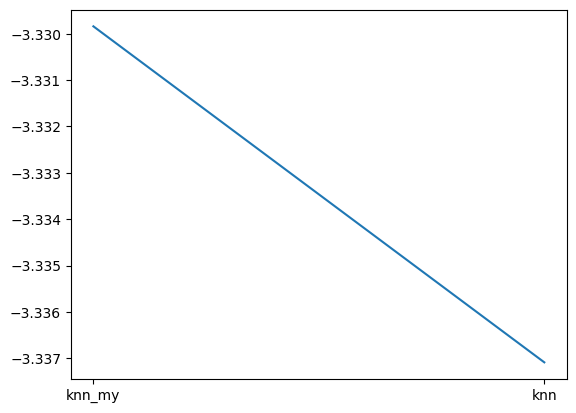

In [32]:
models_knn = ['knn_my', 'knn']
res_knn = [MSE_my_knn, MSE_knn]
log_res_knn = np.log(res_knn)
plt.plot(models_knn, log_res_knn)
plt.show()

Мы видим на данной небольшой выборке очень незначительные отличия, это довольно хороший результат. Конечно самый большой проигрыш нашей модели - скорость и объем данных.

Однако в целом KNN показывает себя плохо в данной задаче в силу формата данных. Хорошо было бы распределить координаты по районам и городам, поскольку самое значимое в цене недвижимости - местоположение объекта. Еще одна идея - не удалять координаты, более того, увеличить их влияние с помощью весов гиперпараметров при подсчете расстояний. Так мы бы могли улучшить результаты.

Протетируем модели со всеми тремя оптимизаторами и сравним с моделью sklearn. Здесь нашей памяти и времени хватит, что б обучить и оттестировать на всей выборке целиком.

Стохастический градиентный спуск

In [39]:
regr_my = LinearRegressor(max_iter=10**12, epoch = 3)
regr_my.fit(X_train, y_train)
pred = regr_my.predict(X_val)

MSE = mean_squared_error(y_val, pred)
MAE = mean_absolute_error(y_val, pred)
RMSE = root_mean_squared_error(y_val, pred)

print(f"MSE: {MSE}, MAE: {MAE}, RMSE: {RMSE}")

  0%|          | 0/3 [00:00<?, ?it/s]

MSE: 1.0254452970556105, MAE: 0.11183075344541435, RMSE: 1.012642729226656


Моментум

In [40]:
regr_my_moment = LinearRegressor(max_iter=10**12, epoch = 3, optimization = 'Momentum')
regr_my_moment.fit(X_train, y_train)
pred_moment = regr_my_moment.predict(X_val)

MSE_moment = mean_squared_error(y_val, pred_moment)
MAE_moment = mean_absolute_error(y_val, pred_moment)
RMSE_moment = root_mean_squared_error(y_val, pred_moment)

print(f"MSE: {MSE_moment}, MAE: {MAE_moment}, RMSE: {RMSE_moment}")

  0%|          | 0/3 [00:00<?, ?it/s]

MSE: 1.0254484024454684, MAE: 0.11183392473819251, RMSE: 1.0126442625352046


AdaGrad

In [44]:
regr_my_ada = LinearRegressor(max_iter=10**12, epoch = 3, optimization = 'AdaGrad')
regr_my_ada.fit(X_train, y_train)
pred_ada = regr_my_ada.predict(X_val)

MSE_ada = mean_squared_error(y_val, pred_ada)
MAE_ada = mean_absolute_error(y_val, pred_ada)
RMSE_ada = root_mean_squared_error(y_val, pred_ada)

print(f"MSE: {MSE_ada}, MAE: {MAE_ada}, RMSE: {RMSE_ada}")

  0%|          | 0/3 [00:00<?, ?it/s]

MSE: 1.0147653495947673, MAE: 0.0925448422726977, RMSE: 1.0073556222083477


Модель Sklearn

In [36]:
regr_orig = LinearRegression()
regr_orig.fit(X_train, y_train)
pred_orig = regr_orig.predict(X_val)

MSE_orig = mean_squared_error(y_val, pred_orig)
MAE_orig = mean_absolute_error(y_val, pred_orig)
RMSE_orig = root_mean_squared_error(y_val, pred_orig)

print(f"MSE: {MSE_orig}, MAE: {MAE_orig}, RMSE: {RMSE_orig}")

MSE: 1.0251031757442863, MAE: 0.11159927548583487, RMSE: 1.012473790151768


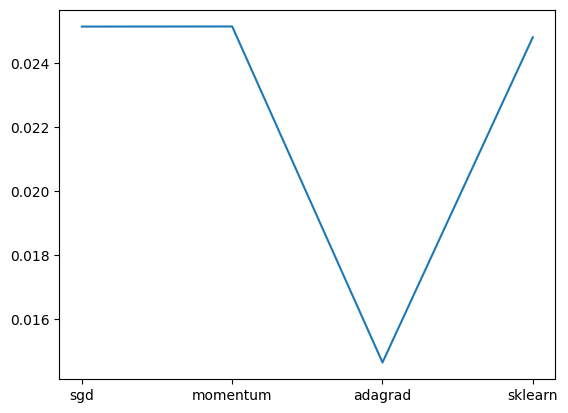

In [45]:
models = ['sgd', 'momentum', 'adagrad', 'sklearn']
res = [MSE, MSE_moment, MSE_ada, MSE_orig]
log_res = np.log(res)
plt.plot(models, log_res)
plt.show()

Как мы видим, модель adagrad показала себя лучше sklearn алгоритма sgd, однако если сравнить результаты sgd и sklearn, мы видим отличия очень незначительны. Это отличный результат.
